In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Callable
from scipy.stats import ortho_group
from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks

from src.dt_helpers.network_dynamics import run_dynamics_step
from src.dt_helpers.plotters import visualize_network_activity
from src.dt_helpers.network_dynamics import compute_individual_neuron_frequency

In [3]:
weights_freq_mod_circuit = np.load("../../data/MANC weights/20250213_testFreqModulatedNet/W.npy")
table_freq_mod_circuit = pd.read_csv("../../data/MANC weights/20250213_testFreqModulatedNet/wTable.csv")

circuit_size = (table_freq_mod_circuit["class"] != "motor neuron").sum()
send_connections = (weights_freq_mod_circuit[np.arange(circuit_size)] != 0).any(0)
receive_connections = (weights_freq_mod_circuit[:, np.arange(circuit_size)] != 0).any(1)
keep = send_connections | receive_connections
weights_circuit = weights_freq_mod_circuit[keep][:, keep]
table_circuit = table_freq_mod_circuit[keep]
weights_circuit[table_circuit["class"] == "motor neuron"] = 0

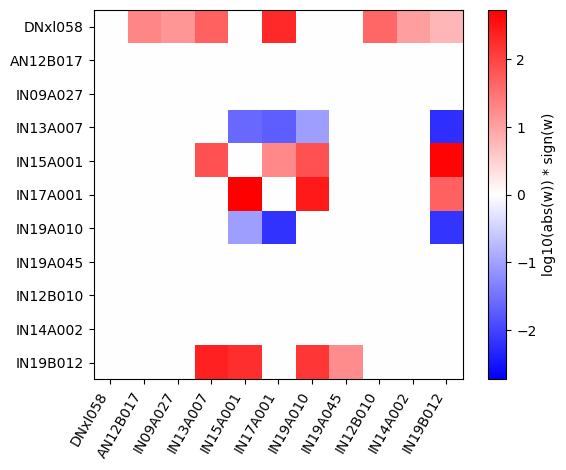

In [4]:
im_weights = np.log10(np.abs(weights_circuit) + 1e-10) * np.sign(weights_circuit)
vval = np.abs(im_weights).max()
plt.imshow(im_weights, cmap="bwr", vmin=-vval, vmax=vval)
plt.xticks(np.arange(keep.sum()), table_circuit["type"].apply(lambda x: x.split(" ")[-1]), rotation=60, ha="right")
plt.yticks(np.arange(keep.sum()), table_circuit["type"])
plt.colorbar(label="log10(abs(w)) * sign(w)")
plt.show()

In [5]:
network_size = circuit_size
network_input = np.zeros(keep.sum())
network_input[table_circuit["class"] == "descending neuron"] = 1
network_input = network_input[table_circuit["class"] != "motor neuron"]

network_weights = weights_circuit[:network_size, :network_size].T / 200

taus_s = 20e-3  # s
dt_s = 1e-5  # s

### Standard simulation

(<Figure size 2000x400 with 1 Axes>,
 <Axes: xlabel='Time (s)', ylabel='Rate (by neuron)'>)

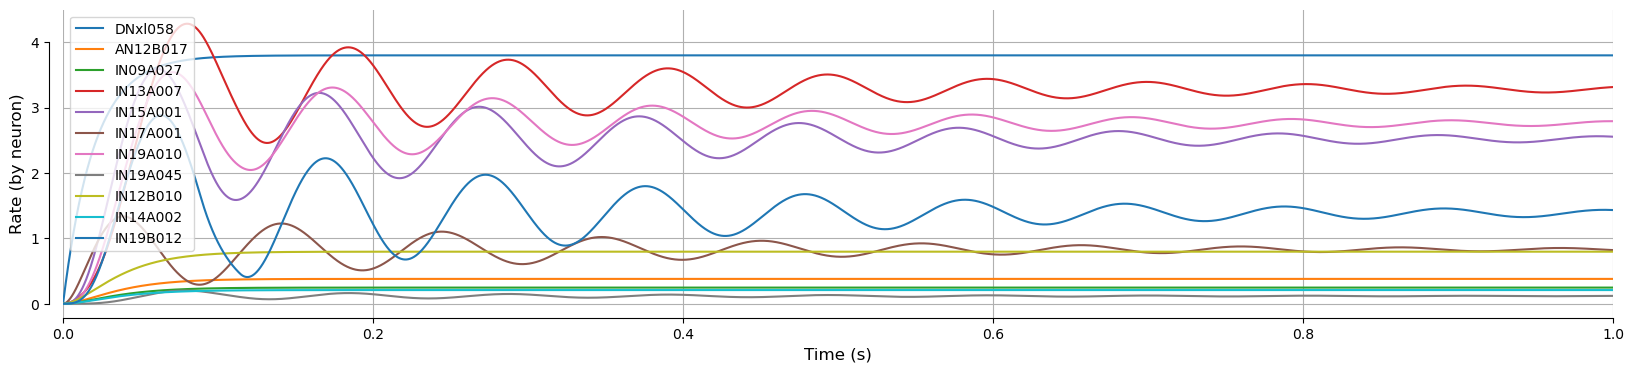

In [6]:
simulation_time_s = 1
num_time_steps = int(simulation_time_s / dt_s)
current_rates = np.zeros(network_size)
history_rates = []
for i in range(num_time_steps):
    current_rates = run_dynamics_step(
        current_rates=current_rates,
        network_input=network_input * 4,
        weights=network_weights,
        taus=taus_s,
        dt=dt_s,
        noise=0,
        activations=lambda x: np.maximum(np.tanh(x / 10) * 10, 0),
        # activations = lambda x: np.maximum(x, 0, x),
        # activations = lambda x: x,
    )
    history_rates.append(current_rates)
history_rates = np.array(history_rates)

visualize_network_activity(
    network_activity=history_rates,
    duration=simulation_time_s,
    dt=dt_s,
    title="",
    legend_labels=table_circuit["type"],
    show_plot=False,
)

In [7]:
network_weights_star = (1 - dt_s/taus_s) * np.eye(network_size) + dt_s * network_weights / taus_s
eigenvalues, eigenvectors = np.linalg.eig(network_weights_star)
print('eigenvals', eigenvalues)
print('eigenvals magnitude', np.abs(eigenvalues))
print('eigenvalues angle (rad)', np.arctan2(eigenvalues.imag, eigenvalues.real))
print('estimated frequencies (Hz)', np.arctan2(eigenvalues.imag, eigenvalues.real) / dt_s / (2 * np.pi))

eigenvals [0.9995    +0.j         0.99998624+0.0006466j  0.99998624-0.0006466j
 0.999059  +0.00035659j 0.999059  -0.00035659j 0.99940952+0.j
 0.9995    +0.j         0.9995    +0.j         0.9995    +0.j
 0.9995    +0.j         0.9995    +0.j        ]
eigenvals magnitude [0.9995     0.99998645 0.99998645 0.99905906 0.99905906 0.99940952
 0.9995     0.9995     0.9995     0.9995     0.9995    ]
eigenvalues angle (rad) [ 0.          0.00064661 -0.00064661  0.00035692 -0.00035692  0.
  0.          0.          0.          0.          0.        ]
estimated frequencies (Hz) [  0.          10.29106468 -10.29106468   5.68059225  -5.68059225
   0.           0.           0.           0.           0.
   0.        ]


In [8]:
freqs = compute_individual_neuron_frequency(
    history_rates,
    dt=dt_s,                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
    num_steps=num_time_steps,
    neuron_names = table_circuit["type"].to_list(),
    max_frequency=40,
)
[(f"neuron-{k}", v) for k, v in freqs.items() if '_' not in k]

[('neuron-DNxl058', 0),
 ('neuron-AN12B017', 0),
 ('neuron-IN09A027', 0),
 ('neuron-IN13A007', 10.00010000100001),
 ('neuron-IN15A001', 10.00010000100001),
 ('neuron-IN17A001', 10.00010000100001),
 ('neuron-IN19A010', 10.00010000100001),
 ('neuron-IN19A045', 10.00010000100001),
 ('neuron-IN12B010', 0),
 ('neuron-IN14A002', 0),
 ('neuron-IN19B012', 10.00010000100001)]

### Frequency modulations with input

In [10]:
input_intensities = np.linspace(0.1, 30, 30)

simulation_time_s = 1

num_time_steps = int(simulation_time_s / dt_s)
individual_neuron_frequencies = pd.DataFrame()
for input_intensity in input_intensities:
    current_rates = np.zeros(network_size)
    history_rates = []
    for i in range(num_time_steps):
        current_rates = run_dynamics_step(
            current_rates=current_rates,
            network_input=network_input * input_intensity,
            weights=network_weights,
            taus=taus_s,
            dt=dt_s,
            noise=0,
            activations=lambda x: np.maximum(np.tanh(x / 10) * 10, 0),
        )
        history_rates.append(current_rates)
    history_rates = np.array(history_rates)
    temp_indi_freq = compute_individual_neuron_frequency(
        history_rates,
        dt=dt_s,
        num_steps=num_time_steps,
        neuron_names=table_circuit["type"].to_list(),
        max_frequency=40,
        use_interpolation=True,
    )
    temp_indi_freq = {k: v for k, v in temp_indi_freq.items() if "_" not in k}
    temp_indi_freq = pd.Series(temp_indi_freq)
    temp_indi_freq.name = "frequency"
    temp_indi_freq = temp_indi_freq.to_frame()
    temp_indi_freq["input_intensity"] = input_intensity
    individual_neuron_frequencies = pd.concat([individual_neuron_frequencies, temp_indi_freq], axis=0)
individual_neuron_frequencies = individual_neuron_frequencies.reset_index()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


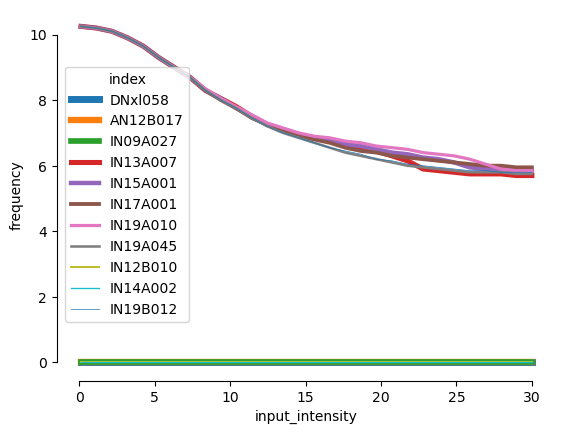

In [11]:
sns.lineplot(
    data=individual_neuron_frequencies,
    x="input_intensity",
    y="frequency",
    hue="index",
    palette="tab10",
    size="index",
    sizes=(0.5,5),
)
sns.despine(offset=1, trim=True)
plt.show()